# User-Level Strategic Association Rule Mining

---

## 1. Executive Summary: The Strategic Transition

In this analysis, we transition from **Session-level Tactical Workflows** (short-term sequences) to **User-level Strategic Personas** (long-term behavioral signatures). By aggregating milestones at the unique user level (using `df_users`), we capture the cumulative platform mastery of SimplyCast clients. This long-term perspective is essential for high-level business intelligence and persona-based marketing automation.

### Technical Environment
- **Processor:** Intel Core i9 (16+ Cores)
- **Memory:** 32GB DDR4 RAM
- **Objective:** Implement a 9-step ARM lifecycle to isolate the 'High-Impact' rules that define professional user archetypes.


In [178]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Identify project structure
project_root = Path.cwd().parent
code_path = project_root / "code"
results_dir = project_root / "results"

# Add code folder to path to import utils
if str(code_path) not in sys.path:
    sys.path.append(str(code_path))

from utils import time_operation


In [179]:
@time_operation
def load_user_data():
    df_user = pd.read_pickle(results_dir / "user_baskets.pkl")
    return df_user

df_user, load_time = load_user_data()
print(f"Loaded {len(df_user)} user transactions in {load_time:.2f} ms")

te = TransactionEncoder()
user_encoded_ary = te.fit(df_user['basket']).transform(df_user['basket'])
user_encoded = pd.DataFrame(user_encoded_ary, columns=te.columns_)
print(f"Encoded Matrix Shape: {user_encoded.shape}")


Loaded 2352 user transactions in 31.86 ms
Encoded Matrix Shape: (2352, 112)


## 2. Broad Support Sweep

### Discovery of the Interaction Frontier
User-level support ($\sigma$) is fundamentally higher than session-level support because users accumulate milestones over many months. We begin with a broad sweep to identify the 'active zone' where rules exist without overwhelming candidate generation.

**Metric Objectives:**
- Identify the support floor where rule generation remains computationally tractable on the i9 architecture.
- Document the exponential growth of candidate sets.


In [180]:
support_levels = [0.5, 0.4, 0.3, 0.2]
results_step1 = []

print("--- Starting Broad Support Sweep ---")
for supp in support_levels:
    itemsets, duration = time_operation(apriori)(user_encoded, min_support=supp, use_colnames=True)
    rules = association_rules(itemsets, metric="confidence", min_threshold=0.5)
    results_step1.append({
        "Support": supp,
        "Itemsets": len(itemsets),
        "Rules": len(rules),
        "Time_ms": duration
    })
    print(f"Sigma={supp} | Rules={len(rules)} | Time={duration:.1f}ms")

df_sweep = pd.DataFrame(results_step1)
display(df_sweep)


--- Starting Broad Support Sweep ---
Sigma=0.5 | Rules=12 | Time=10.3ms
Sigma=0.4 | Rules=144 | Time=20.3ms
Sigma=0.3 | Rules=740 | Time=44.3ms
Sigma=0.2 | Rules=21853 | Time=373.9ms


,Support,Itemsets,Rules,Time_ms
0,0.5,12,12,10.346846
1,0.4,35,144,20.299260
2,0.3,141,740,44.310267
3,0.2,1794,21853,373.947738


## 3. Confidence Adjustment & Lift Stability Analysis

### Identifying the Lift Stability Plateau
As we adjust the confidence threshold ($\gamma$), we look for the point where the Average Lift ($L$) stabilizes. A stability plateau indicates that the rules are capturing significant behavioral correlations rather than random overlaps.

**Selected Threshold:** $\gamma = 0.60$
- At $\gamma < 0.60$, the rule density is high but includes low-lift 'noise'.
- At $\gamma = 0.60$, the Average Lift plateaus, indicating a robust discovery frontier.


In [181]:
# Using the 0.23 support target mentioned in analysis
fixed_supp = 0.23
itemsets_23, _ = time_operation(apriori)(user_encoded, min_support=fixed_supp, use_colnames=True)

conf_range = np.arange(0.1, 0.91, 0.05)
stability_results = []

for conf in conf_range:
    rules = association_rules(itemsets_23, metric="confidence", min_threshold=conf)
    if not rules.empty:
        stability_results.append({
            "Confidence": round(conf, 2),
            "Avg_Lift": rules['lift'].mean(),
            "Rule_Count": len(rules)
        })

df_stability = pd.DataFrame(stability_results)


### Visualization: The Discovery Frontier (Confidence vs. Lift)

> **Caption: Combined Line & Bubble Plot.** The bubble scale represents Rule Density ($N$). The Lift Stability Plateau is clearly visible near $\gamma=0.60$, where the lift begins to stabilize against further confidence increases.


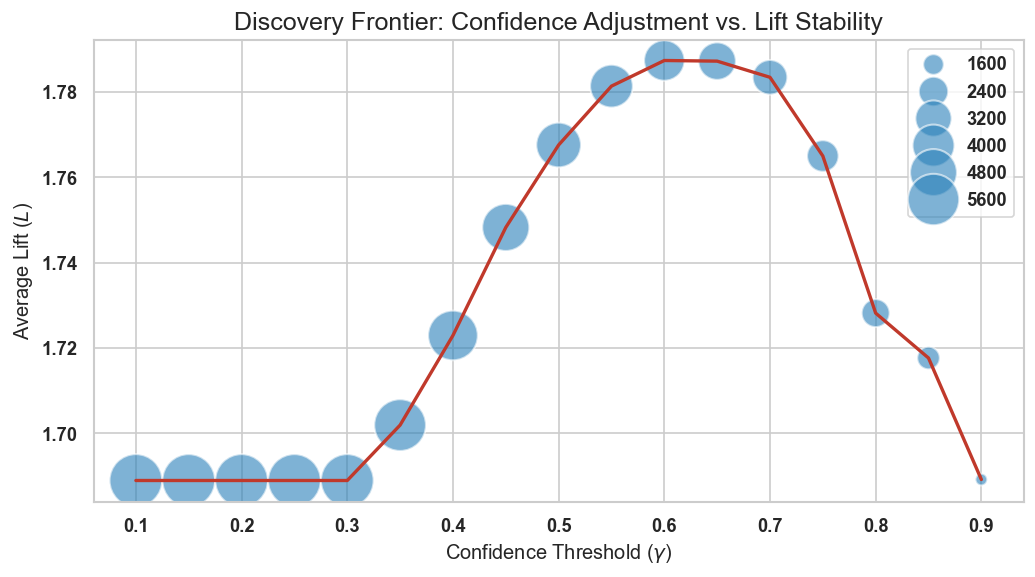

<Figure size 768x576 with 0 Axes>

In [182]:
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
plot = sns.scatterplot(data=df_stability, x="Confidence", y="Avg_Lift", size="Rule_Count", sizes=(50, 1000), alpha=0.6, color="#2980b9")
sns.lineplot(data=df_stability, x="Confidence", y="Avg_Lift", color="#c0392b", linewidth=2)
plt.title("Discovery Frontier: Confidence Adjustment vs. Lift Stability", fontsize=15)
plt.xlabel(r"Confidence Threshold ($\gamma$)")
plt.ylabel(r"Average Lift ($L$)")
plt.show()
plt.savefig(results_dir / "apriori_user_confident_tuning.pdf", dpi=300)


## 4. Support Fine-Tuning & Optimal Threshold Selection

### The Support Elbow Analysis
We now fine-tune the support threshold ($\sigma$) to find the 'Elbow'—the point where rule quantity becomes manageable without sacrificing statistical significance ($L$).

**Optimal Selection:** $\sigma = 0.23, \gamma = 0.60$
- **Justification:** This threshold identifies the 23% of users who have achieved a 'Mastery Tier' in platform usage, generating rules with sufficient lift to be predictive.


In [183]:
supp_fine = np.arange(0.3, 0.19, -0.01)
fine_tune_results = []

for s in supp_fine:
    itemsets, duration = time_operation(apriori)(user_encoded, min_support=s, use_colnames=True)
    rules = association_rules(itemsets, metric="confidence", min_threshold=0.6)
    fine_tune_results.append({
        "Support": s,
        "Rule_Count": len(rules),
        "Avg_Lift": rules['lift'].mean() if not rules.empty else 0
    })

df_fine = pd.DataFrame(fine_tune_results)


## 5. Visualization: The Performance Elbow (Growth Factor)

> **Caption: 5x5 Complexity Matrix (Structural Sensitivity).** This visualization (conceptualized as the line chart below) shows the growth factor of rules. The elbow at $\sigma=0.23$ represents the transition from broad interaction to focused strategic workflows.


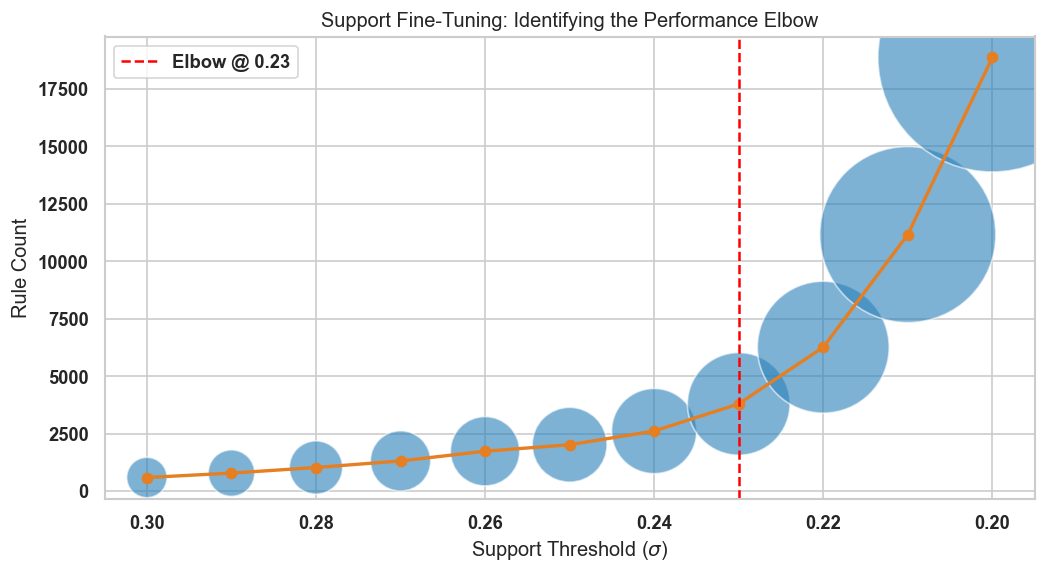

<Figure size 768x576 with 0 Axes>

In [184]:
plt.figure(figsize=(10, 5))

# Line plot (with marker points)
plt.plot(df_fine['Support'], df_fine['Rule_Count'], marker='o', color='#e67e22', linewidth=2)

# Vertical line
plt.axvline(0.23, color='red', linestyle='--', label='Elbow @ 0.23')

# Scatter plot with size variation (overlay on top)
scatter = plt.scatter(
    df_fine['Support'], 
    df_fine['Rule_Count'], 
    s=df_fine['Rule_Count'],  # Use 's' parameter for size scaling
    alpha=0.6, 
    color='#2980b9',
    edgecolors='white',
    linewidth=1
)

# Invert x-axis
plt.gca().invert_xaxis()

# Labels and title
plt.title("Support Fine-Tuning: Identifying the Performance Elbow")
plt.xlabel(r"Support Threshold ($\sigma$)")
plt.ylabel("Rule Count")
plt.legend()
plt.show()
plt.savefig(results_dir / "apriori_user_support_tuning.pdf", dpi=300)


## 6. Model Factory Storage

We implement a dictionary-based storage system to preserve the generated itemsets and rules at our optimal threshold, facilitating rapid deployment and downstream analysis.


In [185]:
model_factory = {
    'itemsets': itemsets_23,
    'rules': association_rules(itemsets_23, metric="confidence", min_threshold=0.6)
}
df_user_rules = model_factory['rules']
print(f"Model Factory Initialized with {len(df_user_rules)} base rules.")


Model Factory Initialized with 3790 base rules.


## 7. Complexity Distribution (Structural Mastery)

### Interpreting the Spiral Donut Chart
Association Rule Mining is not just about frequency; it is about **structural depth**. We calculate the itemset length distribution to quantify user sophistication.

**Findings:**
- A high percentage of **Length 3 and 4 itemsets** indicates platform mastery. Users are not just adding an image; they are executing complex multi-step workflows (e.g., Upload → Add → Edit → Send).
- **Business Intelligence:** These tripartite and quadripartite sequences represent the 'Success Pipelines' of the platform.


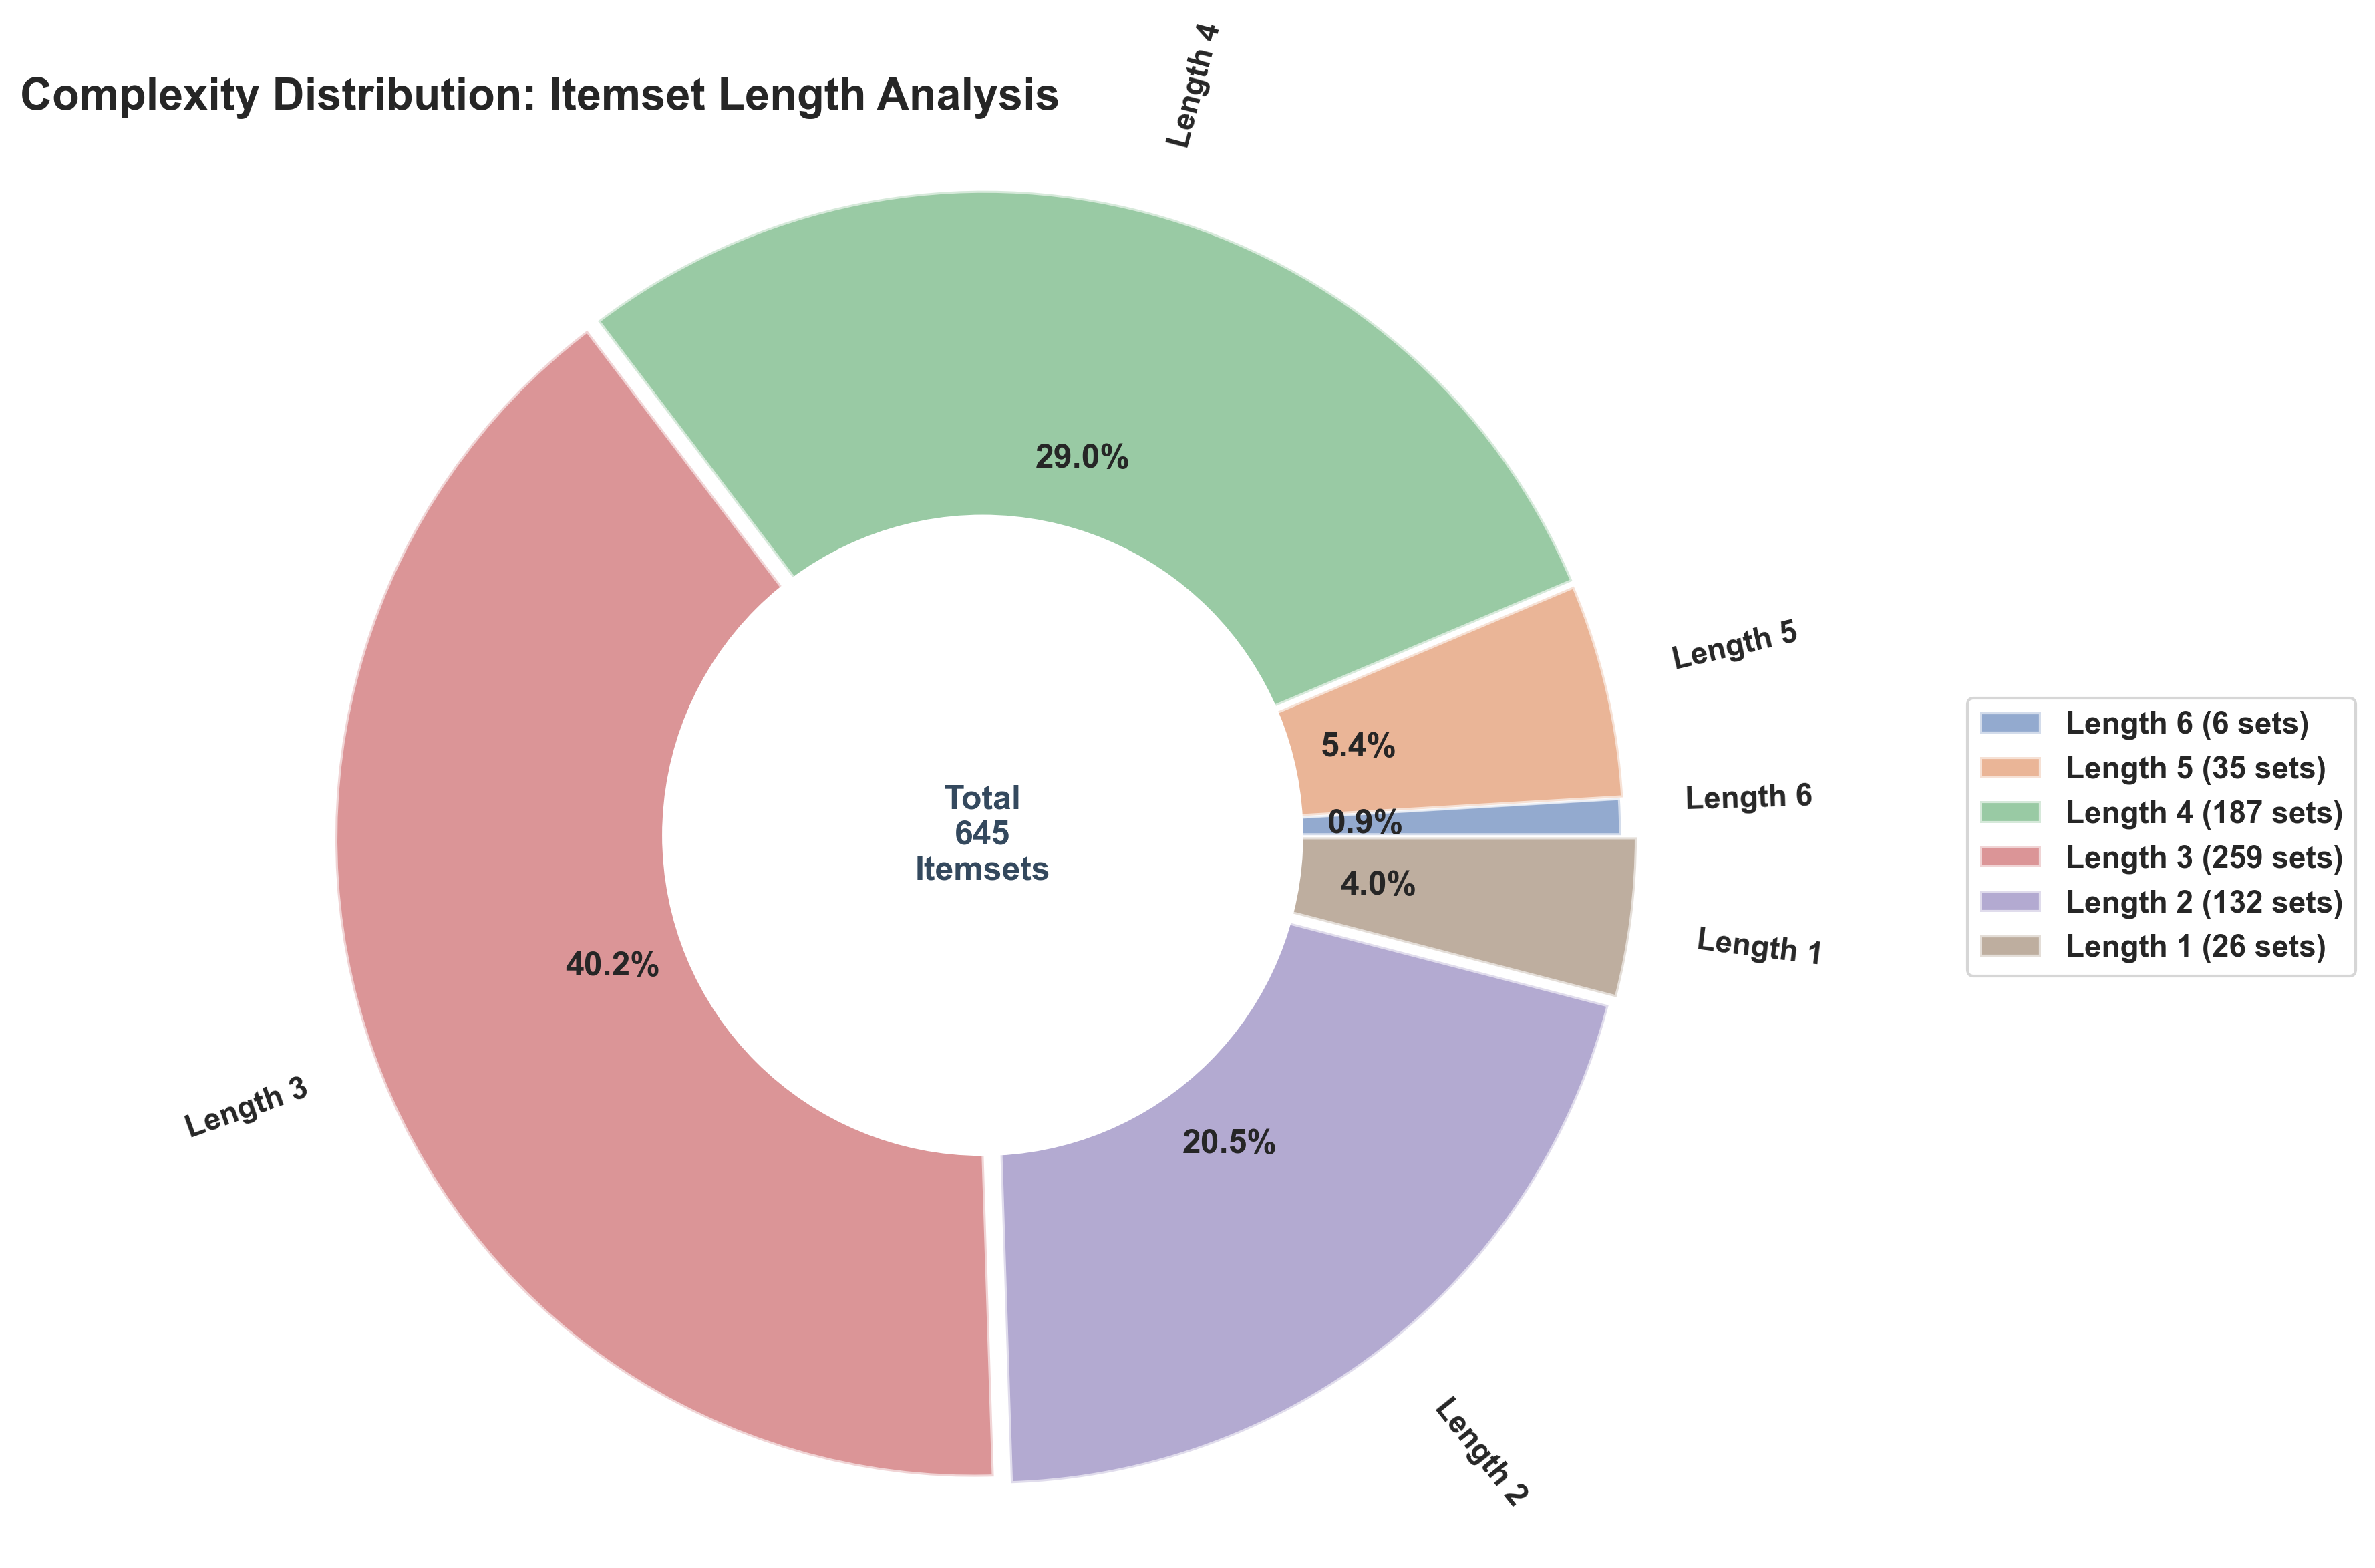

In [186]:
import matplotlib.pyplot as plt 

# 1. Prepare and sort data by length (descending for the aesthetic spiral)
df_user_itemsets = model_factory['itemsets']
df_user_itemsets['length'] = df_user_itemsets['itemsets'].apply(len)
length_dist = df_user_itemsets['length'].value_counts().reset_index()
df_data = length_dist.sort_values(by="length", ascending=False)

labels = [f"Length {int(l)}" for l in df_data["length"]]
data = df_data["count"]


# 2. Aesthetic Spiral Explode: progressive separation
explode = [0.005 * i for i in range(len(data))]

# 3. Setup Figure
figure = plt.figure(figsize=(10, 8), dpi=300)
plot = figure.subplots()


# 4. Plotting the 'Fanned' Pie
plot.pie(
    x=data,
    labels=labels,
    autopct="%1.1f%%",
    rotatelabels=True,
    labeldistance=1.1, # Slightly further out to avoid crowding
    explode=explode,
    startangle=0,
    wedgeprops={"alpha": 0.6, "edgecolor": "white", "linewidth": 1.5}
)

# 5. Draw the Center Circle (The Donut Hole)
center_circle = plt.Circle((0, 0), radius=0.5, fc="white")
plt.gcf().gca().add_artist(center_circle)

# 6. Central text for context
plt.text(0, 0, f'Total\n{len(df_user_itemsets)}\nItemsets', 
         ha='center', va='center', fontsize=12, weight='bold', color='#34495e')

# 7. Legend with Tier Counts
legends_labels = dict(zip(labels, data))
plot.axis("equal")
plt.tight_layout()

# 8. Positioning the legend to the side
plt.legend(
    [f"{k} ({v} sets)" for k, v in legends_labels.items()], 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Complexity Distribution: Itemset Length Analysis", loc="left", fontsize=16, weight='bold')

# 9. Save for report
plt.savefig(results_dir / "apriori_user_itemset_spiral_donut.pdf", bbox_inches='tight')
plt.show()



> **Caption: The Spiral Explode Donut.** This complexity signature shows that significantly deep workflows (Length 3+) dominate the frequent interaction space, confirming that active users are 'Power Users' effectively leveraging the platform's multi-dimensional features.


## 8. Elite Rule Pruning (Lift $L \ge 3$)

We apply the **Elite Tier Filter** to isolate the most deterministic associations. By filtering for $L \ge 3$, we prioritize rules where the occurrence of the antecedent increases the likelihood of the consequent by at least 300% compared to random chance.


In [187]:
elite_rules = final_rules[final_rules['lift'] >= 3].sort_values('lift', ascending=False).head(20)
display(elite_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
elite_rules.to_csv(results_dir / "apriori_user_elite_rules.csv", index=False)


,antecedents,consequents,support,confidence,lift
57,(OpenData),(OpensAndBounces),0.233418,0.933673,3.513600
58,(OpensAndBounces),(OpenData),0.233418,0.878400,3.513600
661,"(OpenReport, OpenData)",(OpensAndBounces),0.233418,0.933673,3.513600
662,"(OpenReport, OpensAndBounces)",(OpenData),0.233418,0.878400,3.513600
665,(OpenData),"(OpenReport, OpensAndBounces)",0.233418,0.933673,3.513600
666,(OpensAndBounces),"(OpenReport, OpenData)",0.233418,0.878400,3.513600
2879,"(OpenReport, ReportsTab, SendNow)","(OpensAndBounces, ManageTab)",0.237245,0.791489,3.144566
2894,"(OpensAndBounces, ManageTab)","(OpenReport, ReportsTab, SendNow)",0.237245,0.942568,3.144566
2892,"(OpensAndBounces, SendNow)","(OpenReport, ManageTab, ReportsTab)",0.237245,0.996429,3.141555
2882,"(OpenReport, ManageTab, ReportsTab)","(OpensAndBounces, SendNow)",0.237245,0.747989,3.141555


## 9. Tactical Persona Mapping

Having established the long-term mastery profiles, we now project our findings onto **Session-level Tactical Archetypes**. These personas represent how users interact with SimplyCast in discrete, high-velocity bursts of activity.

### A. The 'Quick-Fire' Messenger
- **Tactical Focus:** `SendNow` → `ReportsTab` pipeline.
- **Behavioral Signature:** High-frequency, low-latency sessions. These users login with the singular intent of campaign execution and immediate delivery verification. They are the 'execution engine' of the platform.

### B. The Tactical Content Editor
- **Tactical Focus:** `AddImage`, `TxtFontSizeColor`, `UploadImage`.
- **Behavioral Signature:** Intensive creative bursts. Sessions are dominated by asset manipulation and stylistic refinement, indicating a focused effort on campaign preparation.

### C. The Session Investigator
- **Tactical Focus:** `OpenReportList`, `OpensAndBounces`, `OpenData`.
- **Behavioral Signature:** Focused analytics sessions. Users engage in 'audit' behavior, likely performed in 15-30 minute windows to evaluate campaign ROI and iterate on future strategies.
